# **Chargement des bibliothèques et fonctions: à executer**

In [ ]:
## pas besoins de lancer ce code si vous ne travaillez pas avec google colab et si vos fichiers ne sont pas stockés dans votre drive Google
## instalation de google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## à lancer pour importer les bibliothèques nécessaires. (selenieum ne fonctionne pas sur le web)
import warnings
warnings.filterwarnings("ignore")
from time import sleep
# from selenium import webdriver
# from webdriver_manager.chrome import ChromeDriverManager
# from selenium.webdriver.common.keys import Keys
import pandas as pd
import re
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
import datetime
import seaborn as sns
import matplotlib.pyplot as plt


# **Première étape: Préparation et ciblage des données à scraper**

Le site Trustpilot se présente de la façon suivante. Il regroupe les avis client par catégorie : Bank, Travel insurance company, Car dealer… 
Il y a 24 catégories et chaque catégorie contient plusieurs marques. 


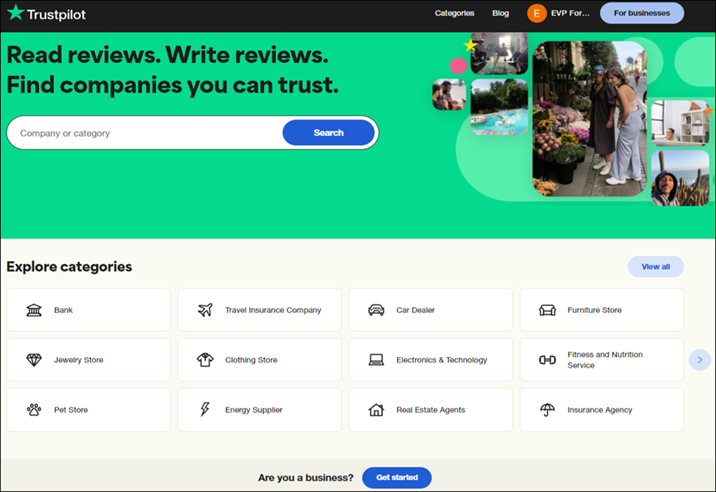 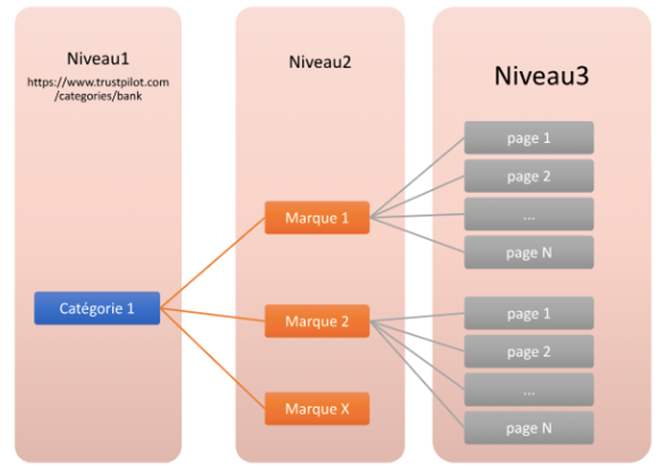



---



On va scrapper des données issues de toutes les catégories afin de voir si le modèle que nous avons créé s’applique mieux à une catégorie plutôt qu’une autre. 
Pour chaque catégorie, il faut scraper les liens des marques qui lui sont rattachées.
Pour accéder à chaque catégorie, il faut remplacer le nom de la catégorie par une variable X puis parcourir la liste des catégories avec une boucle For. 
'https://www.trustpilot.com/categories/bank =====> 'https://www.trustpilot.com/categories/X

In [ ]:
## initialisation des listes vides
categorie, pays ,marque, liens_marque, reviews = [],[],[],[],[]
# #'https://www.trustpilot.com/categories/furniture_store?country=FR'

## Certaines catégories contiennent beaucoup de pages et de marques, ce qui fait planter le code au bout d'un moment. 
## c'est pour cette raison que nous allons scraper morceau par morceau. et enregistrer le résultat de chaque catégorie dans un fichier excel. 

liste_liens1 = ['bank','real_estate_agents','insurance_agency','mortgage_broker']

liste_liens2 = ['energy_supplier','car_dealer','electronics_technology','energy_supplier',
                'bicycle_store','electronics_store','bedroom_furniture_store']

liste_liens3 = ['furniture_store','jewelry_store','clothing_store','pet_store','activewear_store',
                'womens_clothing_store','mens_clothing_store','shoe_store','appliance_store','cosmetics_store']

liste_liens4 = ['travel_insurance_company','fitness_and_nutrition_service','garden_center','travel_agency']

## modifier la liste pour importer les bonnes données, 1,2,3 ou 4 ...
for lien_c in liste_liens4:

  lien = 'https://www.trustpilot.com/categories/'+str(lien_c)+'?country=FR'
  # récupératu du code html de toute la page et le stocker dans une variable: soup
  page = requests.get(lien)
  soup = bs(page.content, "lxml")
  # Sélectionner la partie de la page qui contient les numéros de page
  pagination_div = soup.find('nav', class_='pagination_pagination___F1qS')

  # Extraire les numéros de page en parcourant les éléments de la pagination
  try:
    page_numbers = []
    for item in pagination_div.find_all(['span']):
        page_numbers.append(item.get_text())
  except:
        page_numbers.append(1)
  # print(page_numbers)
  nb_pages = int(page_numbers[-2])
  print(lien_c,'contient :',nb_pages, 'pages!')

  ### début de la boucle qui parcours les pages d'une marque X
  for X in range(1,nb_pages+1):

      sleep(0) # attendre une demi seconde entre chaque page, pas obligé
      lien2 = 'https://www.trustpilot.com/categories/'+str(lien_c)+'?country=FR&page='+str(X)

      # récupératu du code html de toute la page et le stocker dans une variable: soup
      page = requests.get(lien2)
      soup2 = bs(page.content, "lxml")
      soup_marques = soup2.find_all('div', class_ = ("paper_paper__1PY90 paper_outline__lwsUX card_card__lQWDv card_noPadding__D8PcU styles_wrapper__2JOo2"))
      # print(soup_marques)
      # company = soup.find('h1',class_='typography_default__hIMlQ typography_appearance-default__AAY17 title_title__i9V__').text.strip() ## récupérer le nom de la marque

      ## parcourir le code html (soup) pour extraire les informations des balises
      for lien_m in soup_marques:
        # lienss =
        marque.append(lien_m.find('p',class_ ='typography_heading-xs__jSwUz typography_appearance-default__AAY17 styles_displayName__GOhL2').text)
        liens_marque.append(lien_m.find('a',class_ ='link_internal__7XN06 link_wrapper__5ZJEx styles_linkWrapper__UWs5j').get('href'))
        reviews.append(lien_m.find('p',class_ ='typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_ratingText__yQ5S7'))
        # reviews.append(lien_m.find('div',class_ ='styles_rating__pY5Pk'))
        categorie.append(lien_c)
        pays.append("FR")


data = {
      'marque': marque,
      'liens_marque': liens_marque,
      'categorie': categorie,
      'reviews': reviews,
      'pays': pays
      }

# création de Dataframe pour y stocker les données
df_liens = pd.DataFrame(data)

###############  data cleaning: ############################
df_liens['liens_marque'] = df_liens['liens_marque'].str.replace('/review/','')

## extraire le nombre de reviews en utilisant une fonction
def extraire_chiffres(texte):
    pattern = r'\|\</span>([0-9,]+)'
    match = re.search(pattern, str(texte))
    if match:
        chiffres_apres_barre_span = match.group(1)
        return chiffres_apres_barre_span
    elif len(str(texte)) < 8:
        return texte
    else:
        return None
    
    
## appliquer la fonction à la colonne reviews
df_liens['reviews'] = df_liens['reviews'].apply(extraire_chiffres)
## convertir reviews en nombre
df_liens['reviews'] = df_liens['reviews'].str.replace(',','')
# df_liens['reviews'] = df_liens['reviews'].str.replace('None',0)
df_liens['reviews']=df_liens['reviews'].astype(float)
## trier le dataframe
df_liens = df_liens.sort_values(by=['categorie', 'reviews'], ascending=[True, False])

## enregistrer le dataframe traité en csv et excel: ne pas oublier de modififier _liste_liens4 pour ne pas ecraser l'ancien enregistrement
df_liens.to_csv('Avis_trustpilot_liste_liens4.csv')
df_liens.to_excel('Avis_trustpilot_liste_liens4.xlsx')



travel_insurance_company contient : 1 pages!
fitness_and_nutrition_service contient : 8 pages!
garden_center contient : 7 pages!
travel_agency contient : 15 pages!


In [ ]:

df_liens.info()
display(df_liens.head())
# df_liens.describe()
df_marque = df_liens.loc[df_liens['categorie']=='bank'].head(10)

display(df_marque)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 1 to 61
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        62 non-null     object 
 1   liens_marque  62 non-null     object 
 2   categorie     62 non-null     object 
 3   reviews       55 non-null     float64
 4   pays          62 non-null     object 
dtypes: float64(1), object(4)
memory usage: 2.9+ KB


,marque,liens_marque,categorie,reviews,pays
1,Younited Credit,www.younited-credit.com,bank,63800.0,FR
4,Cofidis,cofidis.fr,bank,19135.0,FR
24,Orange Bank,orangebank.fr,bank,14087.0,FR
29,Floabank,floabank.fr,bank,7401.0,FR
5,Anytime,anyti.me,bank,6767.0,FR


,marque,liens_marque,categorie,reviews,pays
1,Younited Credit,www.younited-credit.com,bank,63800.0,FR
4,Cofidis,cofidis.fr,bank,19135.0,FR
24,Orange Bank,orangebank.fr,bank,14087.0,FR
29,Floabank,floabank.fr,bank,7401.0,FR
5,Anytime,anyti.me,bank,6767.0,FR
12,Boursorama Banque,boursorama-banque.com,bank,6379.0,FR
0,Immoprêt,immopret.fr,bank,5301.0,FR
10,Monabanq,www.monabanq.com,bank,4620.0,FR
11,Fortuneo,fortuneo.fr,bank,4614.0,FR
48,Oney,oney.fr,bank,4612.0,FR


In [ ]:
### tests

df_liens.info()
print(df_liens['categorie'].unique())

df_liens.describe()
df_liens.loc[df_liens.liens_marque  =='boursorama-banque.com']
# print(df_liens[13])
print(df_liens['liens_marque'][13])
liste_liens = df_liens['categorie'].unique()
liste_liens

df_marque.info()
# df_liens=df_liens[:5,::]
df_liens['reviews'][0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        62 non-null     object 
 1   liens_marque  62 non-null     object 
 2   categorie     62 non-null     object 
 3   reviews       55 non-null     float64
 4   pays          62 non-null     object 
dtypes: float64(1), object(4)
memory usage: 2.5+ KB
['bank']
noelse.com
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        62 non-null     object 
 1   liens_marque  62 non-null     object 
 2   categorie     62 non-null     object 
 3   reviews       55 non-null     float64
 4   pays          62 non-null     object 
dtypes: float64(1), object(4)
memory usage: 2.9+ KB


5.301

**Préparer les données (liste des marques à scraper)** : l'objectif est de scraper les meilleurs marques, celles qui ont plus d'avis. notre critère de selection est basé sur le nombre de reviews. c'est pour cette raison que nos listes précédentes sont triés par categorie (ordre croissant) puis par reviews (ordre decroissant)

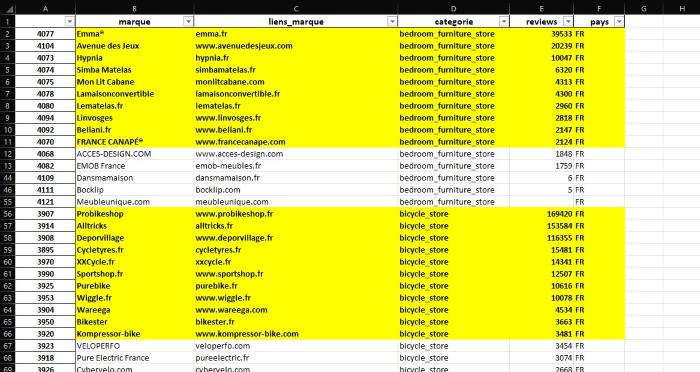

In [ ]:
## regrouper les listes liens catégories dans une seule liste qui contient les dix premier sites de chaque catégorie
## et faire de data cleanning:

df_liste = []
liste_file = ['Avis_trustpilot_liste_liens1.xlsx','Avis_trustpilot_liste_liens2.xlsx','Avis_trustpilot_liste_liens3.xlsx','Avis_trustpilot_liste_liens4.xlsx',]
 # Créez un dictionnaire pour stocker les 10 premières lignes pour chaque valeur unique de colonne2
result = {}

for df_val in liste_file:
  df = pd.read_excel(df_val)
  # Parcourez chaque valeur unique de colonne2
  for value in df['categorie'].unique():
    # Filtrez le DataFrame pour les lignes correspondant à cette valeur unique
    subset = df.loc[df['categorie'] == value ]
    # Prenez les 10 premières lignes de ce sous-DataFrame
    # top_10 = subset.head(10)

    top_10 = subset.iloc[10:20]

    # Stockez-les dans le dictionnaire avec la valeur unique comme clé
    result[value] = top_10

    dataframes_list = list(result.values())
    # Concaténez ces DataFrames en un seul DataFrame
    final_dataframe = pd.concat(dataframes_list)

    df_liste.append(final_dataframe)
    concatenated_df = pd.concat(dataframes_list)

  # concatenated_df.info()

concatenated_df = concatenated_df.drop(columns=['Unnamed: 0'])
display(concatenated_df.head())
concatenated_df.info()

concatenated_df.to_csv('liste_finale_à_scraper2.csv')
concatenated_df.to_excel('liste_finale_à_scraper2.xlsx')



,marque,liens_marque,categorie,reviews,pays
10,Pixpay,pixpay.eu,bank,4154.0,FR
11,La Banque Postale,www.labanquepostale.fr,bank,3445.0,FR
12,Ma French Bank,www.mafrenchbank.fr,bank,3088.0,FR
13,Shine,shine.fr,bank,2382.0,FR
14,Ma Banque BNP Paribas,www.bnpparibas.net,bank,1827.0,FR


<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 10 to 578
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        231 non-null    object 
 1   liens_marque  231 non-null    object 
 2   categorie     231 non-null    object 
 3   reviews       231 non-null    float64
 4   pays          231 non-null    object 
dtypes: float64(1), object(4)
memory usage: 10.8+ KB




---



# **Deuxième étape: Scraper la liste des liens obtenue**


**à cette étape, nous avons une liste de marques (liens à scraper de trustpilot.com)**
**nous allons maintenant lancer le code principale qui va nous permettre de scraper les données.**


In [ ]:
## ouvrir le fichier liste_finale_à_scraper obtenu précedement
## mettre ici le chemin vers le fichier crée précedement
concatenated_df = pd.read_excel('/content/drive/MyDrive/Projet Datascientest/Datas/liste_finale_à_scraper.xlsx')

## le dataframe de travail, choix des catégories à scraper: pour scraper en plusieurs morceaux
df_liens_filtré = concatenated_df.loc[(concatenated_df['categorie']=='energy_supplier') ]

df_liens_filtré.head()

,Unnamed: 0,marque,liens_marque,categorie,reviews,pays
90,4058,Mint Energie,www.mint-energie.com,energy_supplier,8397,FR
91,4059,Mint Energie,www.mint-energie.com,energy_supplier,8397,FR
92,4060,totalenergies.fr,totalenergies.fr,energy_supplier,6007,FR
93,4061,totalenergies.fr,totalenergies.fr,energy_supplier,6007,FR
94,4062,ENGIE Home Services,www.engie-homeservices.fr,energy_supplier,4858,FR
95,4063,ENGIE Home Services,www.engie-homeservices.fr,energy_supplier,4858,FR
96,4064,ilek,ilek.fr,energy_supplier,3509,FR
97,4065,ilek,ilek.fr,energy_supplier,3509,FR
98,4066,ClicAndFioul,www.clicandfioul.com,energy_supplier,2343,FR
99,4067,ClicAndFioul,www.clicandfioul.com,energy_supplier,2343,FR


Conseil pour éviter l'arret de code au bout d'un certain temps :
-	Découper les catégories en quatre sous-catégories car le script s’arrête au bout d’un certain temps.
-	Gérer la pagination c’est-à-dire identifier le nombre de page pour chaque marque sachant que chaque page contient 20 avis. Comme il y a plusieurs pages d'avis pour chaque marque, j'extrait le lien vers la page suivante grâce à son numéro.

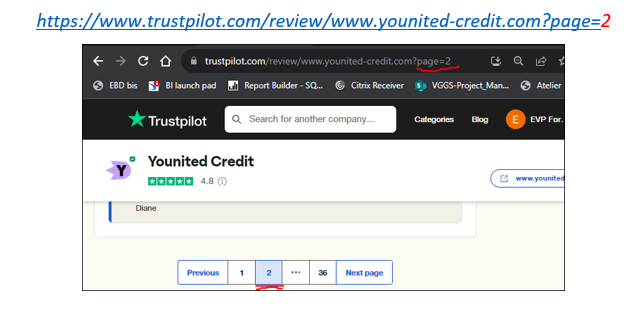

In [ ]:
# webscraping avec beautifulsoup: Projet datascientest/supply_chain : M LAACHIR
## mettre ici la liste des catégories à parcourir: alimenter cette listepar:

# Obtenez la date et l'heure actuelles
date_actuelle = datetime.datetime.now()
# Affichez la date uniquement au format "Année-Mois-Jour"
print("Date du jour (format court) :", date_actuelle.strftime("%d-%m-%Y"))

## ouvrir le fichier liste_finale_à_scraper obtenu précedement !! attention au chemin du fichier, à modifier
concatenated_df = pd.read_excel('/content/drive/MyDrive/Projet Datascientest/Datas/liste_finale_à_scraper2.xlsx')

## le dataframe de travail, choix des catégories à scraper: pour scraper en plusieurs morceaux
df_liens_filtré = concatenated_df.loc[(concatenated_df['categorie']=='clothing_store') ]
# df_liens_filtré = concatenated_df

# liste_liens = ['qonto.com' ,'anyti.me','chanel.com']
liste_cat = df_liens_filtré ['categorie'].unique()
print ('liste des catégories à scraper:\n', liste_cat)

nombre_fichier = 0

for lien_cat in liste_cat:
  ## parcourir la liste des liens pour plusieurs catégories
  Data = {}
  # création des  listes vides
  tout , noms, date_commentaire, date_experience, notes, titre_com, companies, reponses = [],[],[],[],[],[],[],[]
  commentaire, verified ,test, site,nombre_pages , date_scrap, date_reponse, date_rep,categorie_bis = [],[],[],[],[],[],[],[],[]

  df_marque = df_liens_filtré.loc[df_liens_filtré ['categorie'] == lien_cat]

  for lien_c in df_marque['liens_marque']:

    lien = 'https://www.trustpilot.com/review/'+str(lien_c)+'?page=1'

    # récupératu du code html de toute la page et le stocker dans une variable: soup
    try:
      page = requests.get(lien)
      soup = bs(page.content, "lxml")
    except:
      print(f"Une exception s'est produite pour {lien_c}: {e}")
      # continue

    # Sélectionner la partie de la page qui contient les numéros de page
    pagination_div = soup.find('div', class_='styles_pagination__6VmQv')
    # Extraire les numéros de page en parcourant les éléments de la pagination
    page_numbers = []

    try:
      for item in pagination_div.find_all(['span']):
        page_numbers.append(item.get_text())

    # print(page_numbers)
      nb_pages = int(page_numbers[-2])
      print(lien_c, 'contient :',nb_pages, 'pages!')
    except:
      nb_pages = 1

    ### début de la boucle qui parcours les pages d'une marque X
    for X in range(1,nb_pages+1):

        # sleep(0) # attendre une demi seconde entre chaque page, pas obligé

        lien = 'https://www.trustpilot.com/review/'+str(lien_c)+'?page='+str(X)
        # récupératu du code html de toute la page et le stocker dans une variable: soup
        page = requests.get(lien)
        soup = bs(page.content, "lxml")
        # print(soup.prettify())
        avis_clients = soup.find_all('div', attrs = {'class': "styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ"})

        try:
          company = soup.find('h1',class_='typography_default__hIMlQ typography_appearance-default__AAY17 title_title__i9V__').text.strip() ## récupérer le nom de la marque
        except:
          company = None
        ## parcourir le code html (soup) pour extraire les informations des balises
        for avis in avis_clients:

            # tout.append(avis.find('div',class_='styles_reviewContent__0Q2Tg').text.strip())
            try:
              noms.append(avis.find('span',class_='typography_heading-xxs__QKBS8 typography_appearance-default__AAY17').text.strip())
            except:
              noms.append(None)
            try:
              titre_com.append(avis.find('h2',class_='typography_heading-s__f7029 typography_appearance-default__AAY17').text.strip())
            except:
              titre_com.append(None)
            try:
              commentaire.append(avis.find('p').text.strip())
            except:
              commentaire.append(None)
            try:
              reponses.append(avis.find('p',class_='typography_body-m__xgxZ_ typography_appearance-default__AAY17 styles_message__shHhX'))
            except:
              reponses.append(None)
            # try:
              # notes.append(avis.find('img')['alt'])
            # except:
            #   notes.append(None)
            try:
              notes.append(avis.find('div',class_='star-rating_starRating__4rrcf star-rating_medium__iN6Ty'))
            except:
              notes.append(None)
            try:
              date_experience.append(avis.find('p',class_='typography_body-m__xgxZ_ typography_appearance-default__AAY17').text.strip())
            except:
              date_experience.append(None)
            try:
              date_commentaire.append(avis.find('div',class_='styles_reviewHeader__iU9Px').text.strip())
            except:
              date_commentaire.append(None)
            # try:
              # date_reponse.append(avis.find('div',class_='styles_content__Hl2Mi'))
            # except:
            #   noms.append(None)
            try:
              companies.append(company)
            except:
              companies.append(None)
            try:
              site.append(lien)
            except:
              site.append(None)
            try:
              nombre_pages.append(nb_pages)
            except:
              nombre_pages.append(None)
            try:
              categorie_bis.append(lien_cat)
            except:
              categorie_bis.append(None)

            date_scrap.append(date_actuelle.strftime("%d-%m-%Y"))

    nombre_fichier+=1
    print(lien_cat , '/',lien_c, 'lien scrapé N°:***',nombre_fichier)

  # création d'un dictionnaire avec les listes crées précédement
  data = {
          'categorie_bis': categorie_bis,
          'companies': companies,
          'noms': noms,
          'titre_com': titre_com,
          'commentaire': commentaire,
          'reponses': reponses,
          'notes': notes,
          'date_experience': date_experience,
          'date_commentaire': date_commentaire,
          # 'date_reponse': date_reponse,
          'site': site,
          'nombre_pages': nombre_pages,
          'date_scrap': date_scrap
        }

  # création de Dataframe pour y stocker les données
  df = pd.DataFrame(data)
  # enregistrer le dataframe dans un fichier .csv

  df.to_excel('Avis_trustpilot_supply_chain_brut_'+str(lien_cat)+'.xlsx')
# df.to_excel('Avis_trustpilot_supply_chain_brut_total.xlsx')

  print('!!!!!!!!!!!!!!!!!La categorie !!' , lien_cat, '!! est scrapée et enregistrée en Excel!!!!!!!!!!!!!!')

  # print(lien_cat , ': est enregisté avec succèsssssssssssssssssssssssssssssssssssss!!!!!!!!!!!!!!!!')
print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Scrap terminé!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
## premières analyses des données
# print(df.info())


Date du jour (format court) : 24-09-2023
liste des catégories à scraper:
 ['clothing_store']
ccvmode.com contient : 2 pages!
clothing_store / ccvmode.com lien scrapé N°:*** 1
www.footlocker.com contient : 111 pages!
clothing_store / www.footlocker.com lien scrapé N°:*** 2
clothing_store / horizons-lointains.fr lien scrapé N°:*** 3
clothing_store / wordans.fr lien scrapé N°:*** 4
clothing_store / smoon-lingerie.com lien scrapé N°:*** 5
clothing_store / miinto.fr lien scrapé N°:*** 6
clothing_store / maisondemamoulia.fr lien scrapé N°:*** 7
clothing_store / oneill.com/fr lien scrapé N°:*** 8
clothing_store / www.cafecoton.com lien scrapé N°:*** 9
clothing_store / www.leslipfrancais.fr lien scrapé N°:*** 10
!!!!!!!!!!!!!!!!!La categorie !! clothing_store !! est scrapée et enregistrée en Excel!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Scrap terminé!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


Dans cette partie, je regroupe les différents fichiers crées  (les fichiers par catégorie) en un seul fichier

In [ ]:
## pour regrouper les fichiers scrapés en un sel fichier global: final
## !!! dans notre exemple les fichiers sont stockés dans mon Drive Google. il faudra modifier les chemins d'accès aux fichiers dans votre cas!!!

# df_1 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_furniture_store.xlsx'
# df_2 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_bank.xlsx'
# df_3 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_travel_insurance_company.xlsx'
# df_4 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_car_dealer.xlsx'
# df_5 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_jewelry_store.xlsx'

# df_6 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_clothing_store.xlsx'
# df_7 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_electronics_technology.xlsx'
# df_8 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_fitness_and_nutrition_service.xlsx'
# df_9 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_pet_store.xlsx'

# df_10 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_activewear_store.xlsx'
# df_11 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_womens_clothing_store.xlsx'
# df_12 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_bedroom_furniture_store.xlsx'

# df_13 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_appliance_store.xlsx'
# df_14 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_bicycle_store.xlsx'
# df_15 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_mens_clothing_store.xlsx'
# df_16 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_mortgage_broker.xlsx'
# df_17 = '/content/drive/MyDrive/Projet Datascientest/Datas/datas_brut/Avis_trustpilot_supply_chain_brut_shoe_store.xlsx'
# df_18 = '/content/Avis_trustpilot_supply_chain_brut_cosmetics_store.xlsx'
# df_19 = '/content/Avis_trustpilot_supply_chain_brut_electronics_store.xlsx'
# df_20 = '/content/Avis_trustpilot_supply_chain_brut_energy_supplier.xlsx'
# df_21 = '/content/Avis_trustpilot_supply_chain_brut_garden_center.xlsx'
# df_22 = '/content/Avis_trustpilot_supply_chain_brut_insurance_agency.xlsx'
# df_23 = '/content/Avis_trustpilot_supply_chain_brut_real_estate_agents.xlsx'
# df_24 = '/content/Avis_trustpilot_supply_chain_brut_travel_agency.xlsx'

# df_25 = '/content/Avis_trustpilot_supply_chain_brut_clothing_store.xlsx'
# df_26 = '/content/Avis_trustpilot_supply_chain_brut_cosmetics_store.xlsx'
# df_27 = '/content/Avis_trustpilot_supply_chain_brut_energy_supplier.xlsx'
# df_28 = '/content/Avis_trustpilot_supply_chain_brut_garden_center.xlsx'
# df_29= '/content/Avis_trustpilot_supply_chain_brut_womens_clothing_store.xlsx'

df_b1= '/content/drive/MyDrive/Projet Datascientest/Datas/Final_data_scraped_brut1.xlsx'
df_b2= '/content/drive/MyDrive/Projet Datascientest/Datas/Final_data_scraped_brut2.xlsx'
df_b3= '/content/drive/MyDrive/Projet Datascientest/Datas/Final_data_scraped_brut3.xlsx'

# liste_file = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17]
# liste_file = [df_18, df_19, df_20, df_21, df_22, df_23, df_24]
# liste_file = [df_25, df_26, df_27, df_28, df_29]
liste_file = [df_b1, df_b2, df_b3]

 # Créez un dictionnaire pour stocker les 10 premières lignes pour chaque valeur unique de colonne2

resultat = pd.DataFrame()

for df_val in liste_file:
    df = pd.read_excel(df_val)
    resultat = pd.concat([resultat, df], ignore_index=True)

resultat = resultat.drop(columns=['Unnamed: 0'])
# display(concatenated_df.head())
# concatenated_df.info()
resultat.to_csv('Final_data_scraped_brut.csv')
resultat.to_excel('Final_data_scraped_brut.xlsx')
resultat.head()



,categorie_bis,companies,noms,titre_com,commentaire,reponses,notes,date_experience,date_commentaire,site,nombre_pages,date_scrap
0,furniture_store,Made.com Reviews,Dara Teste,I placed an order and paid via Paypal…,I placed an order and paid via Paypal on augus...,NaN,"<div class=""star-rating_starRating__4rrcf star...","Date of experience: March 11, 2023","Mar 11, 2023",https://www.trustpilot.com/review/made.com/fr?...,53,17-09-2023
1,furniture_store,Made.com Reviews,marie,Suspension correspondant à la…,Suspension correspondant à la description fait...,"<p class=""typography_body-m__xgxZ_ typography_...","<div class=""star-rating_starRating__4rrcf star...","Date of experience: October 11, 2022","Oct 26, 2022",https://www.trustpilot.com/review/made.com/fr?...,53,17-09-2023
2,furniture_store,Made.com Reviews,Bruno,Great products and fantastic service.,"Date of experience: October 24, 2022","<p class=""typography_body-m__xgxZ_ typography_...","<div class=""star-rating_starRating__4rrcf star...","Date of experience: October 24, 2022","Oct 24, 2022",https://www.trustpilot.com/review/made.com/fr?...,53,17-09-2023
3,furniture_store,Made.com Reviews,Shurong,Fantastic quality,Fantastic quality! Worth waiting. We ordered t...,"<p class=""typography_body-m__xgxZ_ typography_...","<div class=""star-rating_starRating__4rrcf star...","Date of experience: June 05, 2022","Jun 5, 2022",https://www.trustpilot.com/review/made.com/fr?...,53,17-09-2023
4,furniture_store,Made.com Reviews,Amene,color precise,Hello I like made. It's a bit expensive but an...,"<p class=""typography_body-m__xgxZ_ typography_...","<div class=""star-rating_starRating__4rrcf star...","Date of experience: August 25, 2022","Aug 25, 2022",https://www.trustpilot.com/review/made.com/fr?...,53,17-09-2023


Voici un extrait d'un avis client:

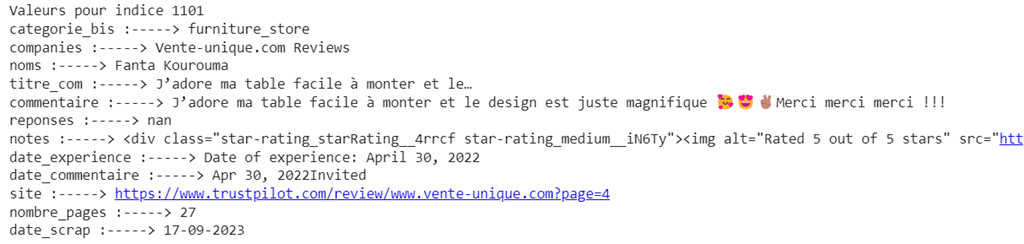

D'après ce que nous voyons ci-dessus, 
Les données scrapées nécessitent un traitement supplémentaire avec text mining. 
Nous allons aussi procéder à la création de nouvelles features engineering.

==> voir le prochain notebook: Notebooks\Projet_supply_chain_2_data_cleaning.ipynb